## UFO Sightings Algorithms Lab
The goal of this notebook is to build out models to use for predicting the legitimacy of a UFO sighting using the XGBoost and Linear Learner algorithm.

What we plan on accompishling is the following:

Load dataset onto Notebook instance memory from S3
1. Cleaning, transforming, analyize, and preparing the dataset
2. Create and train our model (XGBoost))
3. Create and train our model (Linear Learner))
4. First let's go ahead and import all the needed libraries.

In [94]:
import pandas as pd
import numpy as np
from datetime import datetime
import io
import sagemaker.amazon.common as smac

import boto3
from sagemaker import get_execution_role
import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Loading the data from Amazon S3

In [95]:
role = get_execution_role()
bucket = 'dinesh-mane123'
subfolder = 'dataset'
data_key = 'ufo_fullset.csv'

data_location = 's3://{}/{}/{}'.format(bucket, subfolder, data_key)
print(data_location)

df = pd.read_csv(data_location)
df.head()

s3://dinesh-mane123/dataset/ufo_fullset.csv


,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


### Step 2: Cleaning, transforming, analyize, and preparing the dataset

In [96]:
missing_values = df.isnull().values.any()
if(missing_values):
    display(df[df.isnull().any(axis=1)])

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
1024,2011-03-23T18:32:20.473Z,2011-03-22,21:12,NaN,3,1,rain,Deon,Feil,37.681944,-121.766944,Y,N,N,explained
2048,1998-04-23T18:47:16.029Z,1998-04-23,10:07,NaN,40,2,partly cloudy,Vincenzo,Rohan,38.254167,-85.759444,Y,Y,N,explained


In [97]:
df['shape'].value_counts()

circle      6047
disk        5920
light       1699
square      1662
triangle    1062
sphere      1020
box          200
oval         199
pyramid      189
Name: shape, dtype: int64

In [98]:
df['shape'] = df['shape'].fillna(df['shape'].value_counts().index[0])

In [99]:
df['reportedTimestamp'] = pd.to_datetime(df['reportedTimestamp'])
df['eventDate'] = pd.to_datetime(df['eventDate'])

df['shape'] = df['shape'].astype('category')
df['weather'] = df['weather'].astype('category')

df['physicalEvidence'] = df['physicalEvidence'].replace({'Y':1, 'N':0})
df['contact'] = df['contact'].replace({'Y':1, 'N':0})

df['researchOutcome'] = df['researchOutcome'].astype('category')

In [100]:
df.dtypes

reportedTimestamp    datetime64[ns, UTC]
eventDate                 datetime64[ns]
eventTime                         object
shape                           category
duration                           int64
witnesses                          int64
weather                         category
firstName                         object
lastName                          object
latitude                         float64
longitude                        float64
sighting                          object
physicalEvidence                   int64
contact                            int64
researchOutcome                 category
dtype: object

In [101]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

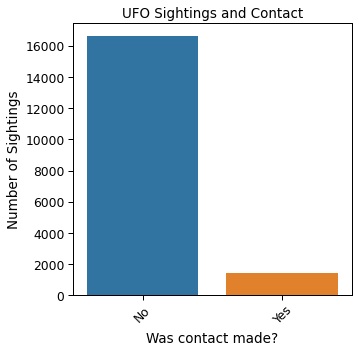

In [102]:
m_cts = (df['contact'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Contact')
ax.set_xlabel('Was contact made?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

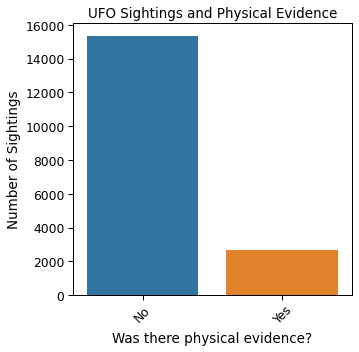

In [103]:
m_cts = (df['physicalEvidence'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Physical Evidence')
ax.set_xlabel('Was there physical evidence?')
ax.set_ylabel('Number of Sightings')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

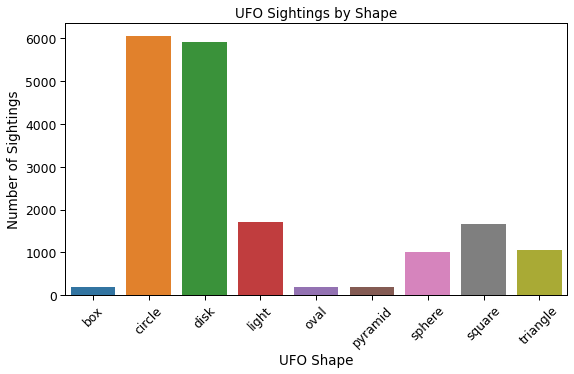

In [104]:
m_cts = (df['shape'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(9,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings by Shape')
ax.set_xlabel('UFO Shape')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

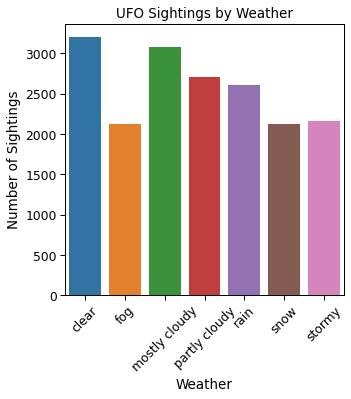

In [105]:
m_cts = (df['weather'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings by Weather')
ax.set_xlabel('Weather')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

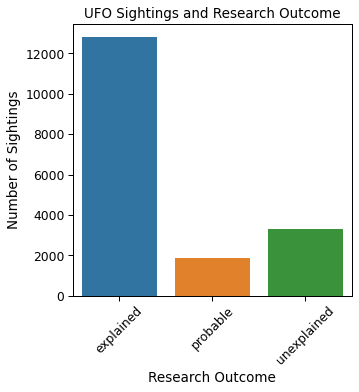

In [106]:
m_cts = (df['researchOutcome'].value_counts())
m_ctsx = m_cts.index
m_ctsy = m_cts.to_numpy()
f, ax = plt.subplots(figsize=(5,5))

sns.barplot(x=m_ctsx, y=m_ctsy)
ax.set_title('UFO Sightings and Research Outcome')
ax.set_xlabel('Research Outcome')
ax.set_ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

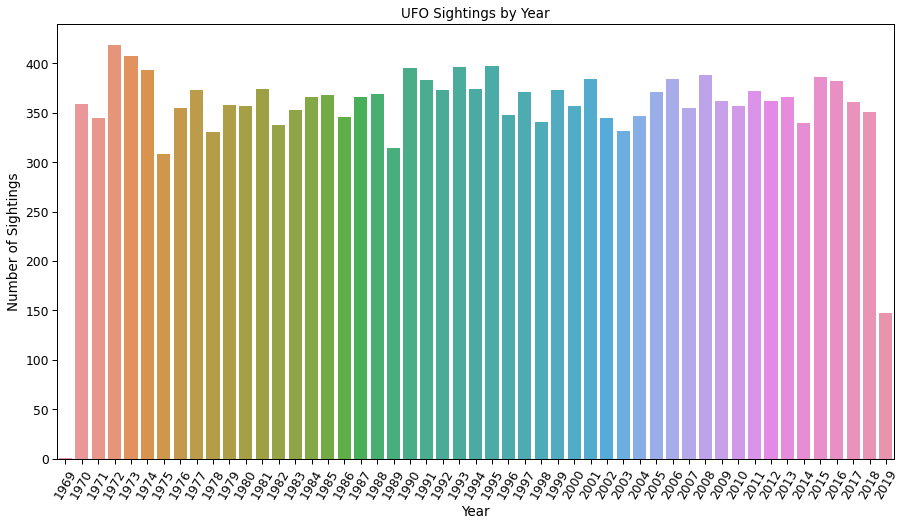

In [107]:
ufo_yr = df['eventDate'].dt.year  # series with the year exclusively

## Set axes ##
years_data = ufo_yr.value_counts()
years_index = years_data.index  # x ticks
years_values = years_data.to_numpy()

## Create Bar Plot ##
plt.figure(figsize=(15,8))
plt.xticks(rotation = 60)
plt.title('UFO Sightings by Year')
plt.ylabel('Number of Sightings')
plt.xlabel('Year')

years_plot = sns.barplot(x=years_index[:60],y=years_values[:60])

In [108]:
df.corr()

,duration,witnesses,latitude,longitude,physicalEvidence,contact
duration,1.000000,0.020679,0.000243,-0.010529,0.016430,0.015188
witnesses,0.020679,1.000000,0.010229,0.003449,0.009186,-0.000651
latitude,0.000243,0.010229,1.000000,-0.394536,0.006465,0.004284
longitude,-0.010529,0.003449,-0.394536,1.000000,-0.004519,-0.004828
physicalEvidence,0.016430,0.009186,0.006465,-0.004519,1.000000,0.693276
contact,0.015188,-0.000651,0.004284,-0.004828,0.693276,1.000000


In [109]:
df.drop(columns=['firstName', 'lastName', 'sighting', 'reportedTimestamp', 'eventDate', 'eventTime'], inplace=True)

In [110]:
df.head()

,shape,duration,witnesses,weather,latitude,longitude,physicalEvidence,contact,researchOutcome
0,circle,4,1,rain,47.329444,-122.578889,0,0,explained
1,disk,4,1,partly cloudy,52.664913,-1.034894,1,0,explained
2,circle,49,1,clear,38.951667,-92.333889,0,0,explained
3,disk,13,1,partly cloudy,41.496944,-71.367778,0,0,explained
4,circle,17,1,mostly cloudy,47.606389,-122.330833,0,0,explained


In [111]:
df = pd.get_dummies(df, columns=['weather', 'shape'])

df['researchOutcome'] = df['researchOutcome'].replace({'unexplained':0, 'explained':1, 'probable':2})

In [112]:
display(df.head())
display(df.shape)

,duration,witnesses,latitude,longitude,physicalEvidence,contact,researchOutcome,weather_clear,weather_fog,weather_mostly cloudy,...,weather_stormy,shape_box,shape_circle,shape_disk,shape_light,shape_oval,shape_pyramid,shape_sphere,shape_square,shape_triangle
0,4,1,47.329444,-122.578889,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4,1,52.664913,-1.034894,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,49,1,38.951667,-92.333889,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,13,1,41.496944,-71.367778,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,17,1,47.606389,-122.330833,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


(18000, 23)

In [113]:
df.columns

Index(['duration', 'witnesses', 'latitude', 'longitude', 'physicalEvidence',
       'contact', 'researchOutcome', 'weather_clear', 'weather_fog',
       'weather_mostly cloudy', 'weather_partly cloudy', 'weather_rain',
       'weather_snow', 'weather_stormy', 'shape_box', 'shape_circle',
       'shape_disk', 'shape_light', 'shape_oval', 'shape_pyramid',
       'shape_sphere', 'shape_square', 'shape_triangle'],
      dtype='object')

In [114]:
df = df.sample(frac=1).reset_index(drop=True)

rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8                       # 80% for training
val_list = (rand_split >= 0.8) & (rand_split < 0.9) # 10% for validation
test_list = rand_split >= 0.9                       # 10% for testing

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]


In [115]:
# Simply moves the researchOutcome attribute to the first position before creating CSV files
pd.concat([data_train['researchOutcome'], data_train.drop(['researchOutcome'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([data_val['researchOutcome'], data_val.drop(['researchOutcome'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

# Next we can take the files we just stored onto our Notebook instance and upload them to S3.
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_train/train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/xgboost_validation/validation.csv').upload_file('validation.csv')

### Step 3: Creating and training our model (XGBoost)

In [116]:
from sagemaker.amazon.amazon_estimator import get_image_uri, image_uris
#container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='latest')
container = image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")

In [117]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/algorithms_lab/xgboost_train'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/algorithms_lab/xgboost_validation'.format(bucket), content_type='csv')



First I like to always create a specific job name.

Next, we'll need to specify training parameters.

1. The xgboost algorithm container
2. The IAM role to use
3. Training instance type and count
4. S3 location for output data/model artifact
5. XGBoost Hyperparameters

In [118]:
job_name = 'ufo-xgboost-job-{}'.format(datetime.now().strftime('%y%m%d%H%M%S'))
print('Here is the job name {}'.format(job_name))

output_location = 's3://{}/algorithm_lab/xgboost_output'.format(bucket)

Here is the job name ufo-xgboost-job-210418152354


In [119]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                   role,
                                   instance_count=1,
                                   instance_type='ml.m4.xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

xgb.set_hyperparameters(objetive='multi:softmax',
                       num_class=3,
                       num_round=100)

data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}

xgb.fit(data_channels, job_name=job_name)

ClientError: An error occurred (AccessDeniedException) when calling the CreateTrainingJob operation: User: arn:aws:sts::740121593245:assumed-role/cfst-3232-a82b5e72d0d056b9066dbde3ab38b846-iamrole-1F7DSQ37EDDH3/SageMaker is not authorized to perform: sagemaker:CreateTrainingJob on resource: arn:aws:sagemaker:us-east-1:740121593245:training-job/ufo-xgboost-job-210418152354 with an explicit deny

In [120]:
print('Here is the location of the trained XGBoost model: {}/{}/output/model.tar.gz'.format(output_location, job_name))

Here is the location of the trained XGBoost model: s3://dinesh-mane123/algorithm_lab/xgboost_output/ufo-xgboost-job-210418152354/output/model.tar.gz


### Step 4: Creating and training our model (Linear Learner)

In [121]:
np.random.seed(0)
rand_split = np.random.rand(len(df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

 # This dataset will be used to train the model.
data_train = df[train_list]

# This dataset will be used to validate the model.
data_val = df[val_list]

# This dataset will be used to test the model.
data_test = df[test_list]

# This rearranges the columns
cols = list(data_train)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_train = data_train[cols]

cols = list(data_val)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_val = data_val[cols]

cols = list(data_test)
cols.insert(0, cols.pop(cols.index('researchOutcome')))
data_test = data_test[cols]

# Breaks the datasets into attribute numpy.ndarray and the same for target attribute.  
train_X = data_train.drop(columns='researchOutcome').values
train_y = data_train['researchOutcome'].values

val_X = data_val.drop(columns='researchOutcome').values
val_y = data_val['researchOutcome'].values

test_X = data_test.drop(columns='researchOutcome').values
test_y = data_test['researchOutcome'].values

In [122]:
train_file = 'ufo_sightings_train_recordIO_protobuf.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object('algorithms_lab/linearlearner_train/{}'.format(train_file)).upload_fileobj(f)